# Topic entropy across the network

In [1]:
# Read data
import pickle
import pandas as pd
import zstandard as zstd
import json
import ujson
import io
import os

# SNA
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import re
from itertools import islice

# Domain study
from collections import Counter
# import urlexpander

import random
random.seed(2024)

In [2]:
def read_excel_sheets_to_dict(filename):
  """
  Reads each sheet from an Excel file and compiles them into a dictionary.

  Args:
    filename: The path to the Excel file.

  Returns:
    A dictionary where keys are sheet names and values are pandas DataFrames.
  """
  excel_file = pd.ExcelFile(filename)
  sheets = {}
  for sheet_name in excel_file.sheet_names:
    sheets[int(re.findall(r'\d+', sheet_name)[0])] = excel_file.parse(sheet_name)
    sheets[int(re.findall(r'\d+', sheet_name)[0])] = sheets[int(re.findall(r'\d+', sheet_name)[0])]['Sentences'].tolist()
  return sheets

In [3]:
# Read data

## Topic modeling results
with open('E:\\._PhD\\Publications\\SocSem_Telegram\\data\\topic_modeling_results.pkl', 'rb') as f:
    topic_modeling_results = pickle.load(f)

topics = read_excel_sheets_to_dict('E:\\._PhD\\Publications\\SocSem_Telegram\\data\\topics.xlsx')

## Dataframe of messages containing alt-tech urls
alt_df = pd.read_excel("E:\\._PhD\\Publications\\SocSem_Telegram\\Code\\alt_df.xlsx")

## Network building

In [4]:
# make edges direction B -> A (message was forwarded from B to A)
edges = list(zip(alt_df['fwd_from'], alt_df['to_id']))
print("Total number of edges:", len(edges))

Total number of edges: 3818


In [5]:
# Delete None values
edges = [e for e in edges if None not in e]
edges = [e for e in edges if not any(np.isnan(x) for x in e)]
print("Total number of non-None edge:", len(edges))

# Set weights
weights = dict(Counter(edges)) # Counter of number of existing forwards between each pair of channels
e = [(k[0], k[1], v) for k, v in weights.items()]

# # Normalize weights in e by total number of messages forwarded from each node
# e = [(k[0], k[1], v/len([x for x in edges if x[0] == k[0]])) for k, v in weights.items()]


Total number of non-None edge: 3427


In [6]:
nodes = list(set([item for sublist in edges for item in sublist]))
print("Total number of nodes:", len(nodes))

# check no duplicates
print("Number of duplicates:", len([k for k, v in dict(Counter(nodes)).items() if v > 1]))

Total number of nodes: 356
Number of duplicates: 0


In [7]:
G=nx.DiGraph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(e)
print("Number of isolated nodes:", len(list(nx.isolates(G))))

Number of isolated nodes: 0


In [8]:
print(G)

DiGraph with 356 nodes and 607 edges


In [9]:
# Print head of list of edges with associated weights
print(list(G.edges(data=True))[:10])

[(1116499975.0, 1446718427, {'weight': 18}), (1398738967.0, 1271719213, {'weight': 5}), (1398738967.0, 1161666782, {'weight': 5}), (1398738967.0, 1362651760, {'weight': 5}), (1398738967.0, 1201072738, {'weight': 5}), (1398738967.0, 1277771372, {'weight': 29}), (1398738967.0, 1250324144, {'weight': 5}), (1398738967.0, 1392836102, {'weight': 6}), (1398738967.0, 1314300626, {'weight': 4}), (1398738967.0, 1200042196, {'weight': 4})]


### Basic community detetion

### Detect

In [ ]:
# !pip install git+https://github.com/taynaud/python-louvain.git

In [101]:
# Detect Louvain communities

from community import community_louvain # https://github.com/taynaud/python-louvain
partition = community_louvain.best_partition(G.to_undirected()) # {node: community ID}
p_descending = {k: v for k, v in sorted(partition.items(), key=lambda item: item[1], reverse=True)}
dict(islice(p_descending.items(), 0, 10))

{1000787017.0: 45,
 1007269511.0: 45,
 1000611791: 45,
 1476086765: 44,
 1470334558.0: 44,
 1001403366.0: 43,
 1000840687: 43,
 1250288610.0: 42,
 1261591630: 42,
 1340348395.0: 42}

In [ ]:
modularity = community_louvain.modularity(partition, G.to_undirected())
print(f"Modularity of the partition: {modularity}")

Modularity of the partition: 0.7142446803884457


In [30]:
# Create dict {C: L} where C is the community label and L is the list of nodes (channels) belonging to that community

from collections import defaultdict

communities = defaultdict(list)

for key, value in sorted(partition.items()):
    communities[value].append(key)

# dict(islice(communities.items(), 0, 3))

In [31]:
# Community size

c_size = {k: len(v) for k,v in communities.items()}
# dict(islice(c_size.items(), 0, 10))

print("Minimum community size:", min(c_size.values()))
print("Maximum community size:", max(c_size.values()))
print("Average community size:", sum(c_size.values())/len(c_size))
print("Share of communities of size 2:", sum([v for k,v in c_size.items() if v == 2])/len(c_size))

Minimum community size: 2
Maximum community size: 45
Average community size: 7.739130434782608
Share of communities of size 2: 1.173913043478261


In [32]:
# Remove communities of size inferior or equal to n
nodes_to_remove = []
for community_id, nodes_in_community in communities.items():
  if len(nodes_in_community) <= 2:
    nodes_to_remove.extend(nodes_in_community)

partition2 = {node: community_id for node, community_id in partition.items() if node not in nodes_to_remove}

In [106]:
# Create communities from partition2

communities2 = defaultdict(list)

for key, value in sorted(partition2.items()):
    communities2[value].append(key)

# Create dictionary of community sizes from communities2
c_size2 = {k: len(v) for k,v in communities2.items()}

print("Minimum community2 size:", min(c_size2.values()))
print("Maximum community2 size:", max(c_size2.values()))
print("Average community2 size:", sum(c_size2.values())/len(c_size2))

Minimum community2 size: 3
Maximum community2 size: 45
Average community2 size: 15.894736842105264


In [ ]:
# Save partition as pickle

# with open('E:\._PhD\Publications\SocSem_Telegram\data\partition.pkl', 'wb') as f:
#     pickle.dump(partition, f)

# with open('partition2.pkl', 'wb') as f:
#     pickle.dump(partition2, f)

# with open('E:\._PhD\Publications\SocSem_Telegram\data\partition.pkl', 'rb') as f:
#     partition = pickle.load(f)

In [20]:
# Save graph

# Add the community label to nodes

for node, community_id in partition.items():
    G.nodes[node]['community'] = community_id

# nx.write_gexf(G, "E:\._PhD\Publications\SocSem_Telegram\data\graph.gexf")

## Topic presence per community

In [ ]:
# Loop through valid topic keys
for topic_id in topics.keys():
    sentences = topics[topic_id]

    # Create a new column in alt_df to indicate if a sentence belongs to the current topic
    alt_df[f'topic_{topic_id}'] = alt_df['text'].apply(lambda x: 1 if x in sentences else 0)

In [13]:
topics.keys()

dict_keys([4, 1, 0, 5, 8, 2, 6, 3, 9, 7])

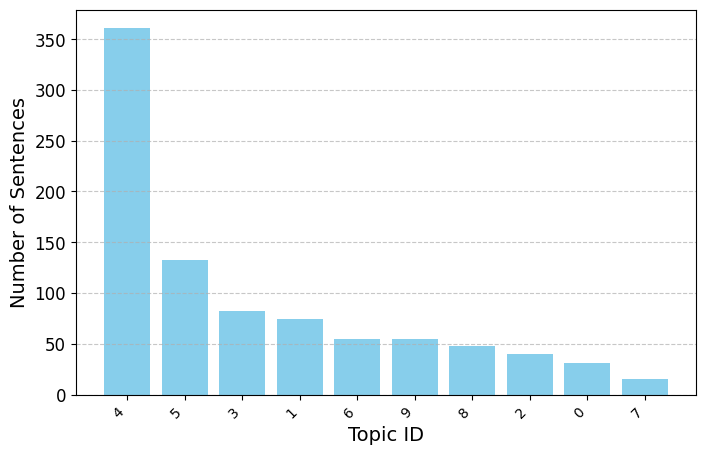

In [14]:
# Store the number of sentences in each topic
topic_counts = {k:len(v) for k,v in topics.items()}

# Sort the topic counts in descending order
sorted_topic_counts = dict(sorted(topic_counts.items(), key=lambda item: item[1], reverse=True))
sorted_topic_counts

# Extract the topic IDs and counts
topic_ids = sorted_topic_counts.keys()
counts = sorted_topic_counts.values()

# Create the histogram
plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
bars = plt.bar(range(len(topic_ids)), counts, color='skyblue')  # Change bar color
plt.xticks(range(len(topic_ids)), topic_ids, rotation=45, ha="right", fontsize=10)  # Set sorted topic IDs as x-axis labels
plt.xlabel("Topic ID", fontsize=14)  # Increased font size for labels
plt.ylabel("Number of Sentences", fontsize=14)
# plt.title("Representation of Topics in the Data", fontsize=16)  # Increased font size for title
# plt.xticks(rotation=45, ha="right", fontsize=12)  # Increased font size for x-axis labels
plt.yticks(fontsize=12)  # Increased font size for y-axis labels
# plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Added gridlines for better readability
plt.show()


## Topic entropy across Louvain communities

In [15]:
# prompt: For each topic, compute the entropy across Louvain communities

# Group messages by community
alt_df['community'] = alt_df['to_id'].map(partition)

# Calculate topic entropy for each topic
topic_entropy = {}
for topic_id in topics.keys():
    # Calculate the probability of each topic occurring in each community
    topic_community_counts = alt_df.groupby(['community', f'topic_{topic_id}'])['id'].count().unstack(fill_value=0)
    topic_community_probs = topic_community_counts.div(topic_community_counts.sum(axis=1), axis=0)

    # Calculate the entropy for each community
    community_entropy = - (topic_community_probs * np.log2(topic_community_probs + 1e-10)).sum(axis=1)

    # Calculate the overall entropy across communities
    topic_entropy[topic_id] = community_entropy.mean()

# Print the topic entropy
print(topic_entropy)


{4: 0.48388221920838115, 1: 0.10010553415527879, 0: 0.09157969910674624, 5: 0.08616432022032583, 8: 0.1402378003607607, 2: 0.06255170276855408, 6: 0.056493427534855735, 3: 0.07292014950736528, 9: 0.06763141485559075, 7: 0.04508007594290245}


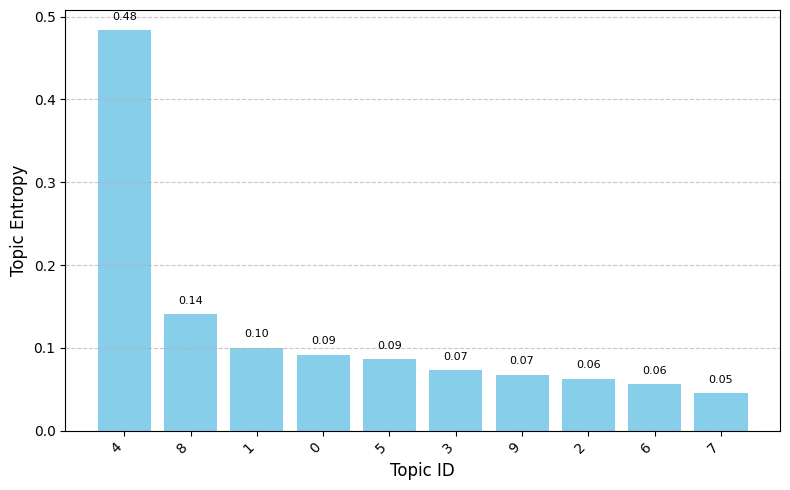

In [16]:
# Extract topic IDs and entropies
topic_ids = list(topic_entropy.keys())
entropies = list(topic_entropy.values())

# Sort topic IDs and entropies in descending order of entropy
sorted_indices = np.argsort(entropies)[::-1]
topic_ids = [topic_ids[i] for i in sorted_indices]
entropies = [entropies[i] for i in sorted_indices]

# Create the histogram
plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
bars = plt.bar(range(len(topic_ids)), entropies, color='skyblue')  # Change bar color
plt.xticks(range(len(topic_ids)), topic_ids, rotation=45, ha="right", fontsize=10)  # Set sorted topic IDs as x-axis labels

# Add entropy values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=8)  # Display approximate entropy value above each bar

# Customize the plot
plt.xlabel("Topic ID", fontsize=12)  # Increase font size
plt.ylabel("Topic Entropy", fontsize=12)
# plt.title("Distribution of Topic Entropies (Sorted)", fontsize=14)
plt.yticks(fontsize=10)  # Adjust y-axis font size
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()

In [17]:
# prompt: Create a dataframe that associates each community to the list of topics that are present in it (according to whether at least one channel in the community is the author of at least one message in the topic)

# Create a dictionary to store the community-topic associations
community_topics = {}

# Iterate over the communities
for community_id in alt_df['community'].unique():
  # Get the messages in the current community
  community_messages = alt_df[alt_df['community'] == community_id]

  # Find the topics present in the community
  topics_in_community = []
  for topic_id in topics.keys():
    if community_messages[f'topic_{topic_id}'].sum() > 0:
      topics_in_community.append(topic_id)

  # Store the topics associated with the community
  community_topics[community_id] = topics_in_community

# Create a DataFrame from the community_topics dictionary
community_topics_df = pd.DataFrame(list(community_topics.items()), columns=['Community', 'Topics'])


In [18]:
community_topics_df.head()

,Community,Topics
0,4.0,"[4, 1, 0, 5, 8, 2, 3, 9]"
1,7.0,"[4, 1, 0, 5, 8, 6, 3, 9, 7]"
2,8.0,"[4, 0, 5, 8, 6, 3, 9, 7]"
3,14.0,"[4, 1, 0, 5, 8, 2, 6, 3, 9, 7]"
4,13.0,"[4, 1, 0, 5, 8, 2, 6, 3, 9]"


In [21]:
# prompt: To each node in G, for i in topics.keys(), add an attribute "topic_i" that equals one if the topic is present in the community that the node belongs to, 0 otherwise.

# Iterate over the nodes in the graph
for node in G.nodes():
  # Get the community ID of the node
  community_id = G.nodes[node]['community']

  # Iterate over the topics
  for topic_id in topics.keys():
    # Check if the topic is present in the community
    if topic_id in community_topics[community_id]:
      # Set the topic attribute to 1
      G.nodes[node][f'topic_{topic_id}'] = 1
    else:
      # Set the topic attribute to 0
      G.nodes[node][f'topic_{topic_id}'] = 0


In [33]:
nodes2 = partition2.keys()
G2 = G.subgraph(nodes2).copy() 

In [34]:
print(G2)

DiGraph with 302 nodes and 573 edges


In [153]:
# prompt: write G to gexf

nx.write_gexf(G, r"E:\._PhD\Publications\SocSem_Telegram\data\alt_tech_network_with_topics.gexf")
nx.write_gexf(G2, r"E:\._PhD\Publications\SocSem_Telegram\data\alt_tech_network_with_topics_no_dyads.gexf")
# G = nx.read_gexf(r"E:\._PhD\Publications\SocSem_Telegram\data\alt_tech_network_with_topics.gexf")

## Topics within topics

### Topic 4

Alternative Platforms and Censorship

In [39]:
# Embeddings

# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
embeddings = model.encode(topics[4], show_progress_bar=True)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [40]:
# Dimensionality reduction

# !pip install umap-learn
import umap.umap_ as umap

umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [41]:
# Clustering

# !pip install hdbscan
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom', core_dist_n_jobs=1).fit(umap_embeddings)

cluster_labels = cluster.fit_predict(umap_embeddings)

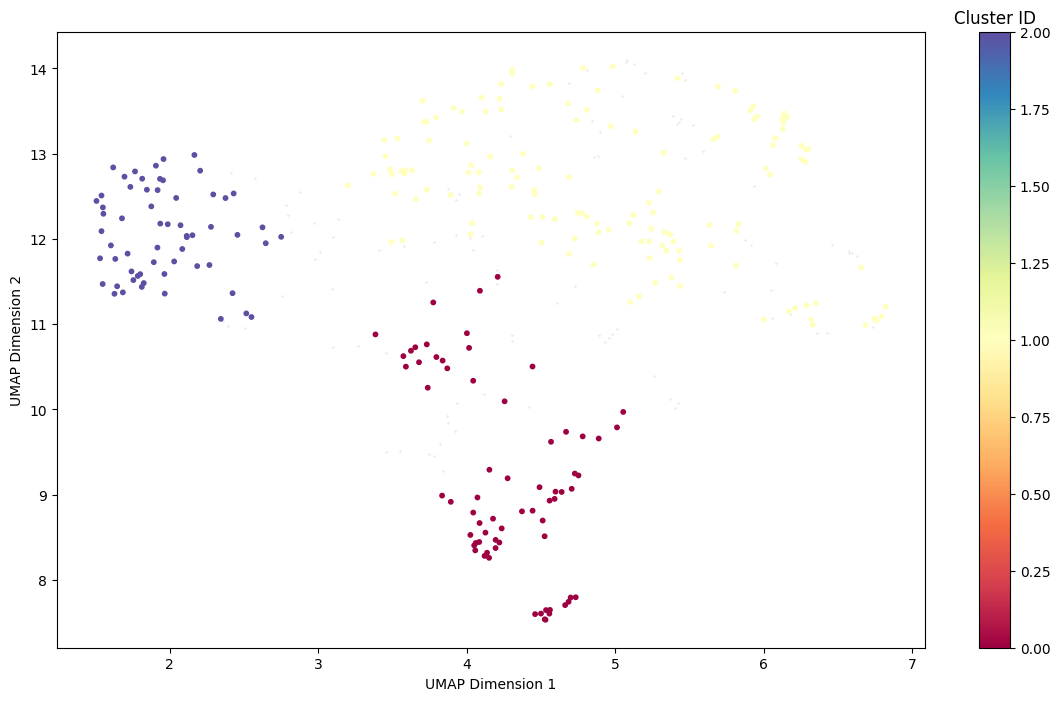

In [42]:
# prompt: Improve the plot produced in the cell above by making it prettier, easy to read, add title to the axes but not the overall plot

import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(14, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='Spectral')
plt.colorbar().ax.set_title('Cluster ID')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
plt.show()


### Topic 9

Religious Reflections and Community Solidarity

In [49]:
# Embeddings

# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
embeddings = model.encode(topics[3], show_progress_bar=True)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [50]:
# Dimensionality reduction

# !pip install umap-learn
import umap.umap_ as umap

umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [51]:
# Clustering

# !pip install hdbscan
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom', core_dist_n_jobs=1).fit(umap_embeddings)

cluster_labels = cluster.fit_predict(umap_embeddings)

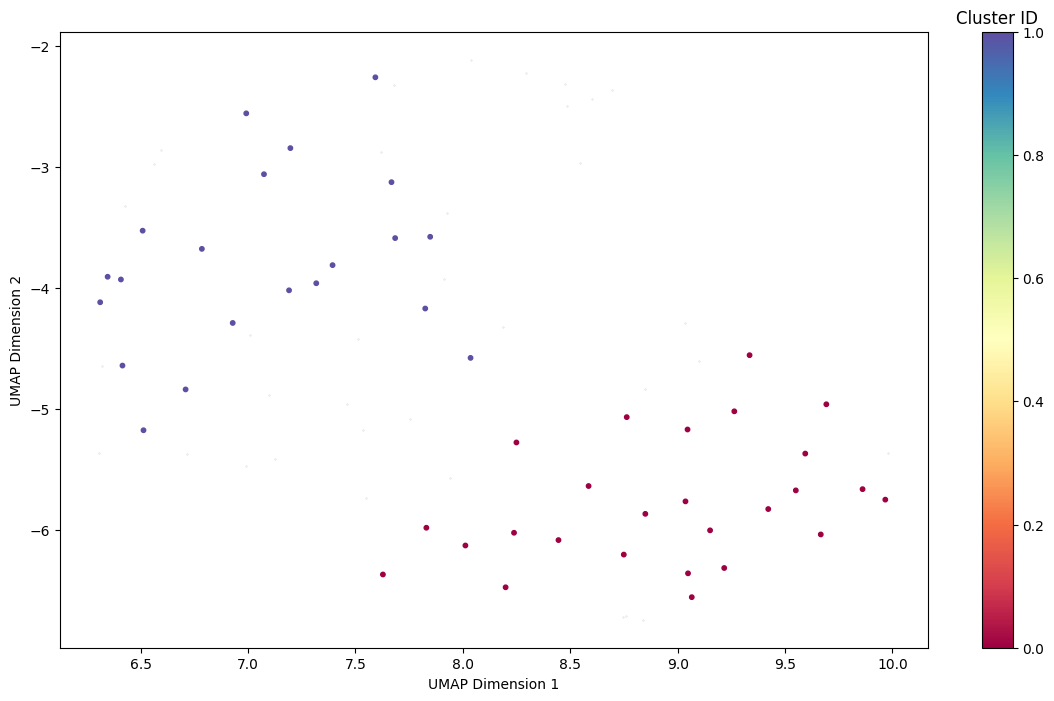

In [52]:
# prompt: Improve the plot produced in the cell above by making it prettier, easy to read, add title to the axes but not the overall plot

import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(14, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='Spectral')
plt.colorbar().ax.set_title('Cluster ID')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
plt.show()


In [56]:
# Export topics to Excel

# Group sentences by topic (cluster label)
topics3 = {}
for sentence, label in zip(topics[3], cluster_labels):
    if label not in topics3:
        topics3[label] = []
    topics3[label].append(sentence)

# Prepare the data for exporting
# Convert each topic to a DataFrame
dataframes = {}
for topic_id, sentences in topics3.items():
    df = pd.DataFrame(sentences, columns=['Sentences'])
    dataframes[f'Topic {topic_id}'] = df

len(topics3[-1])/len(topics[3])

0.4268292682926829

In [57]:
topics3.keys()

dict_keys([0, -1, 1])

In [60]:
# Print the DataFrames to check the output
for topic_name, df in dataframes.items():
    print(f"\n{topic_name}:")
    print(df)

# Create an Excel writer object
with pd.ExcelWriter('E:\\._PhD\\Publications\\SocSem_Telegram\\data\\subtopics3.xlsx', engine='openpyxl') as writer:
    for topic_name, df in dataframes.items():
        df.to_excel(writer, sheet_name=topic_name, index=False)


Topic 0:
                                            Sentences
0      - Biden’s trip to Israel; US/Israeli relations
1            Israel's Internet Censorship War (14:15)
2   From the article, "How Israel and its partisan...
3                The Jewish Led Attack on Free Speech
4             ​How the Jews opened America's Borders.
5           FUCK  BUSH - FUCK ISRAEL & FUCK ZIONISTS.
6       Quit letting Greedy Jews plunder our country.
7   "U.S. Attorney General Bill Barr holds a summi...
8               How the Israel Lobby Controls America
9                        Only the Jews seek that.—Dr.
10  ​The Jewish state of Israel & the 'Irgun Terro...
11                        Muslim bad - Jewish - good.
12                                  7:08 "I'm jewish"
13     The Jewish Question explained in four minutes.
14        Jewish Author Promotes Paedophilia to Teens
15  KEN O’KEEFE - US MILITARY FIGHTING FOR ISRAEL ...
16      Jewish Noahide Law and U.S. Public Law 102-14
17        Aren't J

## Write the graph with subtopics

In [61]:
alt_df.columns

Index(['Unnamed: 0', 'date', 'id', 'message', 'to_id', 'fwd_from', 'url',
       'text', 'community', 'topic_4', 'topic_1', 'topic_0', 'topic_5',
       'topic_8', 'topic_2', 'topic_6', 'topic_3', 'topic_9', 'topic_7'],
      dtype='object')

In [62]:
alt_df['topic_3_1'] = alt_df['text'].apply(lambda x: 1 if x in topics3[1] else 0)
alt_df_topic_3_1 = alt_df[alt_df['topic_3_1'] == 1]
len(alt_df_topic_3_1['to_id'].unique())

7

In [72]:
G.nodes[1074780161]

{'community': 0,
 'topic_4': 0,
 'topic_1': 0,
 'topic_0': 0,
 'topic_5': 0,
 'topic_8': 1,
 'topic_2': 0,
 'topic_6': 0,
 'topic_3': 0,
 'topic_9': 1,
 'topic_7': 0,
 'topic_3_1': 0}

In [74]:
# Iterate over the nodes in the graph
for node in G.nodes():
  if node in [x for x in alt_df_topic_3_1['to_id'].unique()]:
    # Set the topic_9_1 attribute to 1
    G.nodes[node]['topic_3_1'] = 1
  else:
    # Set the topic_9_1 attribute to 0
    G.nodes[node]['topic_3_1'] = 0


In [75]:
# Number of nodes for which topic_xxx = 1
sum(nx.get_node_attributes(G, 'topic_3_1').values())

7

In [76]:
# Write the graph

nx.write_gexf(G, r"E:\._PhD\Publications\SocSem_Telegram\data\alt_tech_network_with_topics3.gexf")

In [ ]:
# # prompt: Compute the entropy of topics9[1] across Louvain communities

# # Group messages by community
# alt_df['community'] = alt_df['to_id'].map(partition2)

# # Calculate topic entropy for topics9[1]
# topic_entropy = {}
# topic_id = 1  # Assuming topics9[1] is the topic of interest

# # Calculate the probability of the topic occurring in each community
# topic_community_counts = alt_df.groupby(['community', 'topic_9_1'])['id'].count().unstack(fill_value=0)
# topic_community_probs = topic_community_counts.div(topic_community_counts.sum(axis=1), axis=0)

# # Calculate the entropy for each community
# community_entropy = - (topic_community_probs * np.log2(topic_community_probs + 1e-10)).sum(axis=1)

# # Calculate the overall entropy across communities
# topic_entropy[topic_id] = community_entropy.mean()

# # Print the topic entropy
# print(topic_entropy)


{1: 0.15443430813910353}
